---
title: "Open University Data Analysis"
author: "John Arhin"
date: "2024-06-01"
format: 
  html:
    code-fold: true
    toc: true
---

# Libraries

We load the libraries used in this analysis.

In [1]:
# main libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np

# sklearn pre-processing models
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split

# sklearn metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# Data

We download the data from the site [Open Learning Analytics  OU Analyse  Knowledge Media Institute  The Open University](https://analyse.kmi.open.ac.uk/open_dataset).[^1]  

We create variables to load the data, and we use it throughout this analysis.

[^1]: Kuzilek J., Hlosta M., Zdrahal Z. Open University Learning Analytics dataset Sci. Data 4:170171 doi: 10.1038/sdata.2017.171 (2017).

In [2]:
data = "/home/john/Open University Learning Analytics Dataset/Data/anonymisedData/"
# data = "."

## Courses

We load the courses data

In [3]:
courses_df = pd.read_csv(os.path.join(data, "courses.csv"), header=0, sep=",")

courses_df.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


## Student Interaction With Course Materials

We load the data regarding the student interaction in the vle (virtual learning environment).

In [4]:
student_vle_df = pd.read_csv(os.path.join(data, "studentVle.csv"), header=0, sep=",")

student_vle_df.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


### Student VLE aggregation
We aggregate the total number of clicks (i.e. usage) of each piece of VLE material

In [5]:
student_vle_df.groupby(
    [
        "code_module",
        "code_presentation",
        "id_student",
        "id_site",
    ]
).agg(total_clicks=pd.NamedAgg(column="sum_click", aggfunc="sum"))

total_clicks
code_module code_presentation id_student id_site              
AAA         2013J             11391      546614            138
                                         546644             35
                                         546645             15
                                         546647              9
                                         546650             10
...                                                        ...
GGG         2014J             2684003    897076              1
                                         897121              1
                                         897150              9
                                         897151             17
                                         897152              1

[1960496 rows x 1 columns]

## VLE

We look at the different categories (column `activity_type`) for each vle element (column `id_site`).

In [6]:
vle_df = pd.read_csv(os.path.join(data, "vle.csv"), header=0, sep=",")

vle_df.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [7]:
vle_df.drop(columns=["week_from", "week_to"])

,id_site,code_module,code_presentation,activity_type
0,546943,AAA,2013J,resource
1,546712,AAA,2013J,oucontent
2,546998,AAA,2013J,resource
3,546888,AAA,2013J,url
4,547035,AAA,2013J,resource
...,...,...,...,...
6359,897063,GGG,2014J,resource
6360,897109,GGG,2014J,resource
6361,896965,GGG,2014J,oucontent
6362,897060,GGG,2014J,resource


# Data Munging

We take the student VLE information and we attach the activity_type information from the VLE dataframe using a left join on the columns:

* id_site,
* code_module, and
* code presentation.

We then group by the columns:

* code_module,
* code_presentation,
* id_student, and
* actvity_type

and we take the sum of the sum_clicks column, and we call the column total_clicks.

Finally, we transform the rows of the column activity_type into columns, and we fill the column

In [8]:
#| label: tbl-student-vle-agg-df
#| tbl-cap: "student-vle-agg-df"

student_vle_agg_df = (
    student_vle_df.merge(
        vle_df.drop(columns=["week_from", "week_to"]),
        on=["id_site", "code_module", "code_presentation"],
        how="left",
    )
    .groupby(["code_module", "code_presentation", "id_student", "activity_type"])
    .agg(total_clicks=pd.NamedAgg(column="sum_click", aggfunc="sum"))
    .reset_index()
    .pivot(
        index=["code_module", "code_presentation", "id_student"],
        columns="activity_type",
        values="total_clicks",
    )
    .fillna(value=0)
    .reset_index()
)

student_vle_agg_df.head()

activity_type,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,0.0,0.0,0.0,0.0,193.0,0.0,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0
1,AAA,2013J,28400,10.0,0.0,0.0,0.0,417.0,0.0,324.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0
2,AAA,2013J,30268,0.0,0.0,0.0,0.0,126.0,0.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,2.0,0.0,0.0,0.0,634.0,1.0,432.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0
4,AAA,2013J,32885,0.0,0.0,0.0,0.0,194.0,4.0,204.0,...,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0


## Student Registration

We load the student registration data.

In [9]:
student_registration_df = pd.read_csv(
    os.path.join(data, "studentRegistration.csv"), header=0, sep=","
)

student_registration_df.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


We create colums to compute the length of time a student was registered on the course. Also, we  compute whether or not a student completes the course.

In [10]:
#| label: tbl-student_registration_df
#| tbl-cap: "student registration dataframe"


student_registration_df = student_registration_df.assign(
    student_course_lifetime=lambda x: x.date_unregistration - x.date_registration,
).assign(student_course_complete=lambda x: x.date_unregistration.isna())

student_registration_df.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,student_course_lifetime,student_course_complete
0,AAA,2013J,11391,-159.0,NaN,NaN,True
1,AAA,2013J,28400,-53.0,NaN,NaN,True
2,AAA,2013J,30268,-92.0,12.0,104.0,False
3,AAA,2013J,31604,-52.0,NaN,NaN,True
4,AAA,2013J,32885,-176.0,NaN,NaN,True


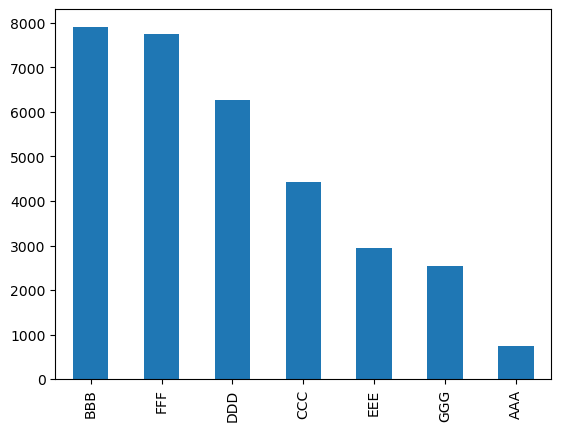

In [11]:
student_registration_df["code_module"].value_counts().plot(kind = 'bar');

We can see that the course BBB has nearly 8000 students registering for the course while courses such as AAA have a much lower number of students at below 1000.

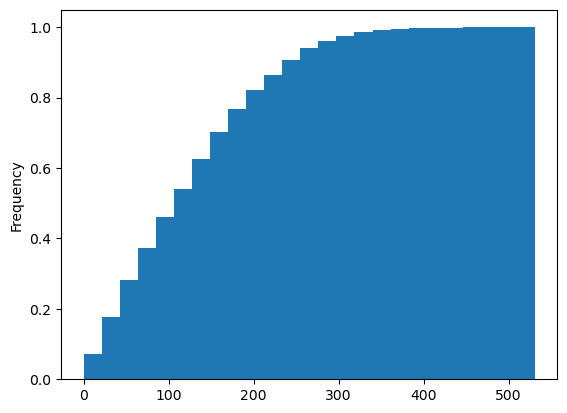

In [12]:
student_registration_df.student_course_lifetime.plot(kind="hist", density=True, cumulative=True, bins = 25);

We can see that overall 50% of students are signed onto courses for about 125 days or less. 

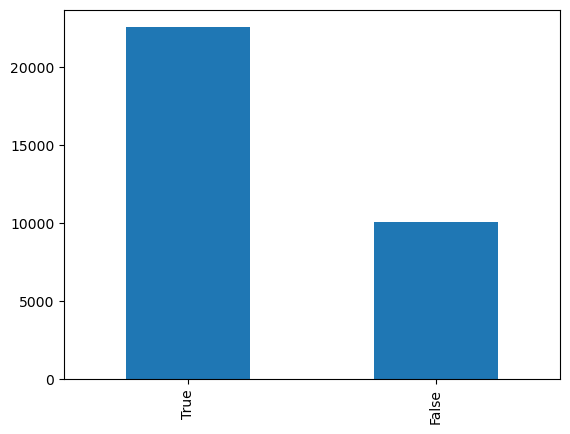

In [13]:
student_registration_df.student_course_complete.value_counts().plot(kind = 'bar');

We can see overall that over 20,000 students completed the courses, while just over 10,000 students did not finish the course after registering.

In [14]:
student_unregistered_df = student_registration_df.groupby(
    ["code_module", "code_presentation", "student_course_complete"]
).agg(counts=pd.NamedAgg(column="code_module", aggfunc="count"))

student_unregistered_df["code_presentation_proportion"] = student_unregistered_df[
    "counts"
] / student_unregistered_df.groupby(["code_module", "code_presentation"])[
    "counts"
].transform(
    "sum"
)

student_unregistered_df

counts  \
code_module code_presentation student_course_complete           
AAA         2013J             False                        60   
                              True                        323   
            2014J             False                        66   
                              True                        299   
BBB         2013B             False                       505   
                              True                       1262   
            2013J             False                       647   
                              True                       1590   
            2014B             False                       489   
                              True                       1124   
            2014J             False                       736   
                              True                       1556   
CCC         2014B             False                       898   
                              True                       1038   
            2014J             False                      1049   
                              True                       1449   
DDD         2013B             False                       431   
                              True                        872   
            2013J             False                       684   
                              True                       1254   
            2014B             False                       489   
                              True                        739   
            2014J             False                       631   
                              True                       1172   
EEE         2013J             False                       243   
                              True                        809   
            2014B             False                       173   
                              True                        521   
            2014J             False                       302   
                              True                        886   
FFF         2013B             False                       411   
                              True                       1203   
            2013J             False                       677   
                              True                       1606   
            2014B             False                       461   
                              True                       1039   
            2014J             False                       831   
                              True                       1534   
GGG         2013J             False                        65   
                              True                        887   
            2014B             False                       100   
                              True                        733   
            2014J             False                       124   
                              True                        625   

                                                       code_presentation_proportion  
code_module code_presentation student_course_complete                                
AAA         2013J             False                                        0.156658  
                              True                                         0.843342  
            2014J             False                                        0.180822  
                              True                                         0.819178  
BBB         2013B             False                                        0.285795  
                              True                                         0.714205  
            2013J             False                                        0.289227  
                              True                                         0.710773  
            2014B             False                                        0.303162  
                              True                                         0.696838  
            2014J             Fa

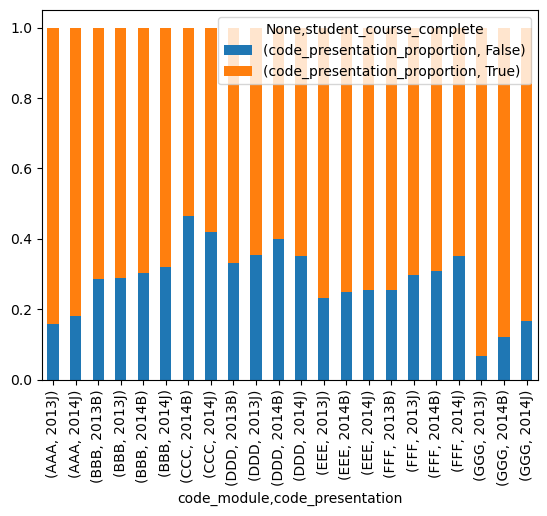

In [15]:
student_unregistered_df[["code_presentation_proportion"]].unstack().plot(
    kind="bar", stacked=True
);

In [16]:
# student_unregistered_df[["code_presentation_proportion"]].reset_index().loc[
#     lambda x: x["student_course_complete"] == True
# ][["code_module", "code_presentation", "code_presentation_proportion"]].plot(
#     x="code_presentation", y="code_presentation_proportion", kind="bar", legend=None
# );
# 
# student_unregistered_df[
#     student_unregistered_df.index.get_level_values("student_course_complete") == True
# ].droplevel(2, axis=0)[["code_presentation_proportion"]].plot(kind="bar", legend=None);

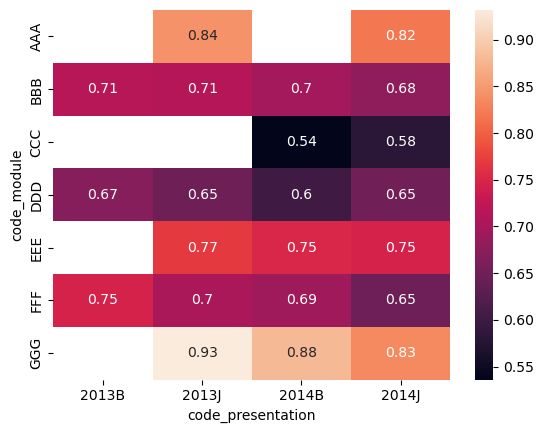

In [17]:
heatmap_df = (
    student_unregistered_df[["code_presentation_proportion"]]
    .reset_index()
    .loc[lambda x: x["student_course_complete"] == True][
        ["code_module", "code_presentation", "code_presentation_proportion"]
    ]
)

heatmap_df = heatmap_df.pivot(
    index="code_module",
    columns="code_presentation",
    values="code_presentation_proportion",
)

sns.heatmap(heatmap_df, annot=True);

Note here that in the code presentation after the year the letter 'B' stand for course started in February and the letter 'J' stands for courses starting in October.

All of the courses have the trend of proportions of students finishing the course decreasing over the cohorts and years, except for the course CCC where it increases from 54% for the 2014 February cohort to 58% for the 2014 October cohort.

# Machine Learning

We create a dataframe to be used for modelling by taking the dataframe shown in @tbl-student-vle-agg-df, and merging it with the student registration dataframe as shown in @tbl-student_registration_df.


In [18]:
model_df = student_vle_agg_df[
    (student_vle_df.code_module == "AAA") & (student_vle_df.code_presentation == "2013J")
    ].merge(
    student_registration_df[
        ["code_module", "code_presentation", "id_student", "student_course_complete"]
    ],
    on=["code_module", "code_presentation", "id_student"],
)


model_df.student_course_complete = model_df.student_course_complete.replace({True: 1, False: 0})

model_df

/tmp/ipykernel_87587/2068679203.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_df = student_vle_agg_df[


,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,...,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,student_course_complete
0,AAA,2013J,11391,0.0,0.0,0.0,0.0,193.0,0.0,138.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,1
1,AAA,2013J,28400,10.0,0.0,0.0,0.0,417.0,0.0,324.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1
2,AAA,2013J,30268,0.0,0.0,0.0,0.0,126.0,0.0,59.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0,0
3,AAA,2013J,31604,2.0,0.0,0.0,0.0,634.0,1.0,432.0,...,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,1
4,AAA,2013J,32885,0.0,0.0,0.0,0.0,194.0,4.0,204.0,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,GGG,2014J,2640965,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,9.0,0.0,1
29224,GGG,2014J,2645731,0.0,0.0,0.0,0.0,65.0,5.0,167.0,...,0.0,0.0,0.0,152.0,0.0,109.0,0.0,47.0,0.0,1
29225,GGG,2014J,2648187,0.0,0.0,0.0,0.0,0.0,1.0,63.0,...,0.0,0.0,0.0,130.0,0.0,19.0,0.0,20.0,0.0,1
29226,GGG,2014J,2679821,0.0,0.0,0.0,0.0,118.0,0.0,65.0,...,0.0,0.0,0.0,31.0,0.0,9.0,0.0,12.0,0.0,0


In [19]:
unwanted_columns = ['student_course_complete', 'code_module', 'code_presentation', 'id_student']

wanted_columns = [x for x in list(model_df.columns) if x not in unwanted_columns]

In [20]:
X = model_df[wanted_columns]

y = model_df[[
    'student_course_complete'
]]

We create the test and train datasets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1324)

# transpose
#X_train = X_train.transpose()
#y_train = y_train.transpose()
#X_test = X_test.transpose()
#y_test = y_test.transpose()

In [22]:
scaler = MinMaxScaler().fit(X_train)

# apply scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Custom Machine Learning Model

We write a simple classification model using the classes of `BaseEstimator` and `ClassifierMixin` from `sklearn.base`. We setup the new class to have the following method structure:

* `__init__`
* `fit`
* `predict`, and 
* `predict_proba`.

Note here that the method 'predict_proba` is only used for classification.

We use the general stucture below for our custom model

In [23]:
class CustomLogisticRegression(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass

    def predict(self, X, y=None):
        pass

    def predict_proba(self, X, y=None):
        pass

In [24]:
# from numpy import log, dot, e
# from numpy.random import rand

class CustomLogisticRegression:

    def __init__(self, X):

        # seed
        np.random.seed(1327)
        
        # initialisations
        number_cols = X.shape[1]
        self.w = np.random.randn(number_cols, 1)
        self.b = 0
        self.m = number_cols
    
    def sigmoid(self, z): return 1/(1+np.exp(-z))
    
    def fit(self, X, y, epochs=5000, alpha=0.1):        
                 
        for _ in range(epochs):

            # forward proporgation
            Z = np.dot(X, self.w) + self.b
            A = self.sigmoid(Z)

            # backward proporgation
            dZ = A - y
            dw = 1/self.m * np.dot(X.T, dZ)
            db = 1/self.m * np.sum(dZ.T, axis=0)

            # updates
            self.w =+ -alpha * dw
            self.b =+ -alpha * db

            # extract only value
            self.b =self.b.values[0]
    
    def predict(self, X):        
        # Predicting with sigmoid function
        Z = np.dot(X, self.w) + self.b
        A = self.sigmoid(Z)
        # Returning binary result
        return (pd.DataFrame(A) > 0.5).astype(int)

We initialise the custom model object. 

In [25]:
logreg = CustomLogisticRegression(X_train_scaled)

We fit the model to the training data.

In [26]:
logreg.fit(X_train_scaled, y_train, epochs = 10000, alpha=0.001)

In [27]:
y_pred = logreg.predict(X_test_scaled)

In [28]:
confusion_matrix(y_test, y_pred)

array([[ 136, 1675],
       [  88, 5408]])

We compute the confusion matrix above.

In [29]:
logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_accuracy

0.7587245107431231

In [30]:
from IPython.display import Markdown as md


md(f"We see that our model has {logreg_accuracy:.2%} accuracy")

We see that our model has 75.87% accuracy